In [11]:
from datetime import datetime
from lib_data import fetch_data, fetch_spot_prices
import lib_predictive as lp
import lib_prescriptive as lpsa
import pandas as pd
import timeit

In [12]:
pd.set_option('display.max_columns', None)
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
API_KEY = 'YOUR_DMI_API_KEY'
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg

In [13]:
# descriptive analysis
# data processing
def collect_and_process_historical_data():
    historical_spot_prices = fetch_spot_prices(start_date, asof)
    historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', STATION_ID, API_KEY, historical=True)
    historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', STATION_ID, API_KEY, historical=True)

    df = lp.preprocess_data(historical_spot_prices, historical_wind_data, historical_temp_data)
    return df

DA_exec_time = timeit.timeit(collect_and_process_historical_data, number=1)

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
234/234 - 2s - 9ms/step - loss: 0.0207 - val_loss: 0.0074
Epoch 2/20
234/234 - 1s - 2ms/step - loss: 0.0135 - val_loss: 0.0064
Epoch 3/20
234/234 - 1s - 2ms/step - loss: 0.0120 - val_loss: 0.0058
Epoch 4/20
234/234 - 1s - 2ms/step - loss: 0.0115 - val_loss: 0.0054
Epoch 5/20
234/234 - 1s - 2ms/step - loss: 0.0111 - val_loss: 0.0053
Epoch 6/20
234/234 - 1s - 2ms/step - loss: 0.0112 - val_loss: 0.0053
Epoch 7/20
234/234 - 1s - 2ms/step - loss: 0.0112 - val_loss: 0.0053
Epoch 8/20
234/234 - 1s - 2ms/step - loss: 0.0114 - val_loss: 0.0055
Epoch 9/20
234/234 - 1s - 2ms/step - loss: 0.0117 - val_loss: 0.0057
Epoch 10/20
234/234 - 1s - 2ms/step - loss: 0.0120 - val_loss: 0.0059
Epoch 11/20
234/234 - 1s - 2ms/step - loss: 0.0124 - val_loss: 0.0064
Epoch 12/20
234/234 - 1s - 2ms/step - loss: 0.0128 - val_loss: 0.0068
Epoch 13/20
234/234 - 1s - 2ms/step - loss: 0.0132 - val_loss: 0.0073
Epoch 14/20
234/234 - 1s - 2ms/step - loss: 0.0139 - val_loss: 0.0080
Epoch 15/20
234/234 - 1s - 2m

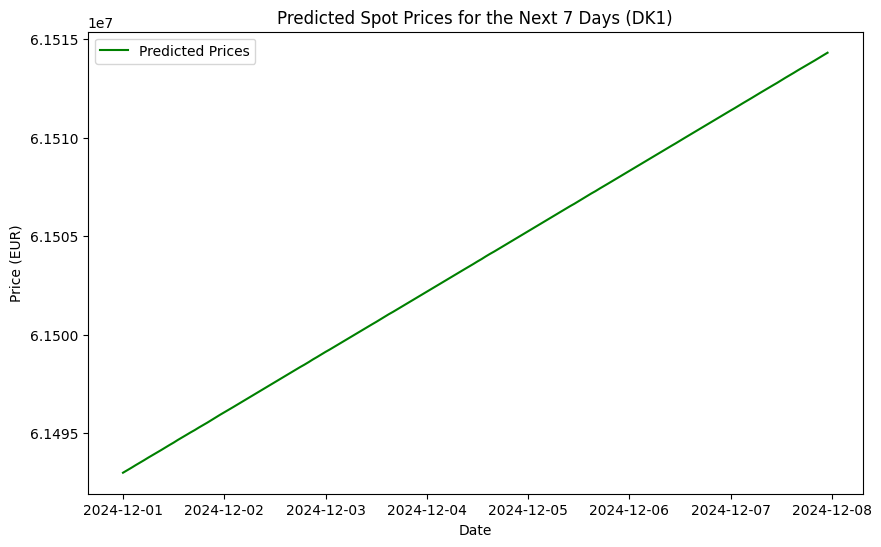

In [14]:
# predictive analysis
# create prediction model
def create_model():
    df = collect_and_process_historical_data()

    features = ['day_of_year','weekday' ,'hour' ,'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'epoch' ,'wind_speed', 'temperature']
    target = 'PriceEUR'

    X_train, X_val, X_test, y_train, y_val, y_test = lp.split_data(df, features, target)

    X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = lp.normalize_data(X_train, X_val, X_test, y_train, y_val, y_test)
    X_train, X_val, X_test = lp.reshape_data_LSTM(X_train, X_val, X_test)
    
    model, history = lp.train_lstm_model(X_train, y_train, X_val, y_val)
    predictions = lp.evaluate_model(model, X_test, y_test)

# predict future values
def predict():
    model = lp.load_model('lstm_model.keras')

    future_df = lp.predict_future(model, asof)

    return future_df

PDA_create_model_exec_time = timeit.timeit(create_model, number=1)
PDA_predict_exec_time = timeit.timeit(predict, number=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


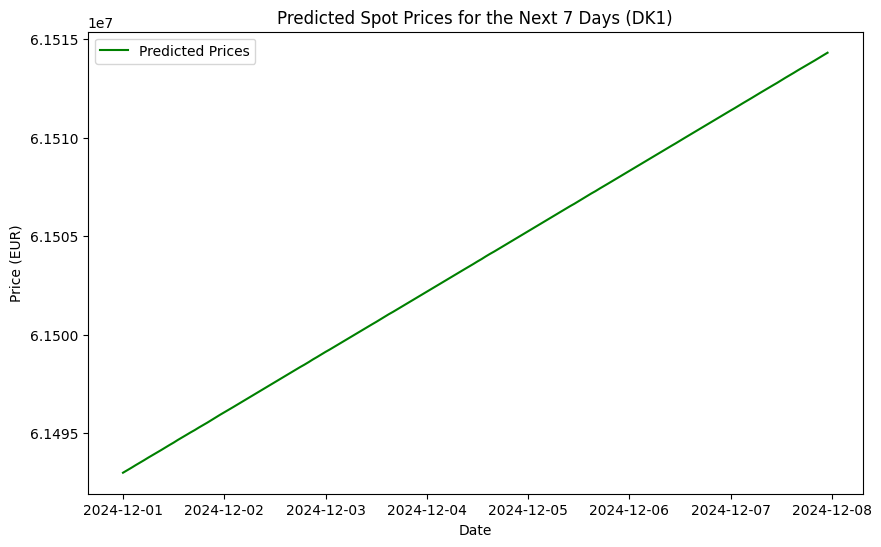

Optimal Profit: 0.00 EUR


In [15]:
# prescriptive analysis
# prescribing a solution
def prescribe():
    # Battery specifications (Tesla battery)
    battery_capacity = 200  # MWh
    charging_power = 100 # MW
    discharging_power = 100 # MW
    efficiency = 0.9

    future_df = predict()
    future_df['HourDK'] = pd.to_datetime(future_df['HourDK'])
    future_df.set_index('HourDK', inplace=True)
    future_prices = future_df['PriceEUR'].values

    # prescribe a solution
    charge, discharge, soc = lpsa.battery_arbitrage(future_prices, battery_capacity, charging_power, discharging_power, efficiency)

    return charge, discharge, soc

PSA_exec_time = timeit.timeit(prescribe, number=1)

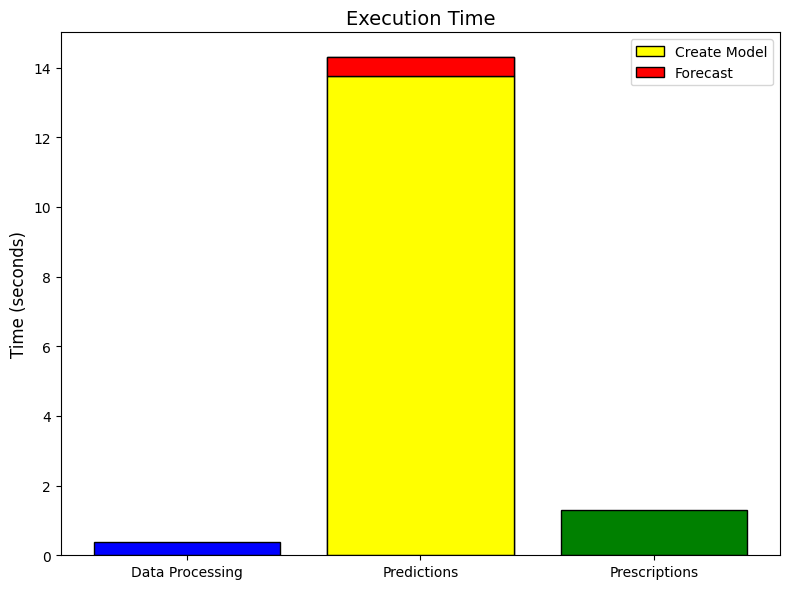

0.379924500011839
13.742771199904382
0.5518909000093117
1.3037233999930322


In [16]:
from lib_descriptive import plot_exec_time
plot_exec_time(DA_exec_time, PDA_create_model_exec_time, PDA_predict_exec_time, PSA_exec_time)

print(DA_exec_time)
print(PDA_create_model_exec_time)
print(PDA_predict_exec_time)
print(PSA_exec_time)